# MMA Fight Outcome Model

The purpose of this project is to create a binary classification model to predict the outcome of an MMA fight (win or loss for a given fighter) based on a set of features extracted from the database found at https://www.kaggle.com/datasets/danmcinerney/mma-differentials-and-elo?select=masterMLpublic.csv

The database consists of over 6000 unique fights and 513 feature columns for which data is collected on each fight. This project will explore two distinct models. The first will tackle the problem using a feed-forward neural network, whereas the second model will utilise an SVM classifier.

#### For more information on the problem statement and methodology, please read Summary.pdf or README.md

## I. DATA PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# REMOVING ENTRIES WITH MISSING DATA

data = pd.read_csv('masterdataframe.csv')
data = data.dropna()
start_col = data.columns.get_loc("reach") 
end_col = data.columns.get_loc("precomp_recent_avg_ground_strikes_attempts_per_min") + 1  
features = data.iloc[:, start_col:end_col]
target = data['result']  

# SPLITTING DATA INTO TRAINING, VALIDATION, TESTING SETS

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# NORMALISING

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Example visualisation of processed data for feature 200

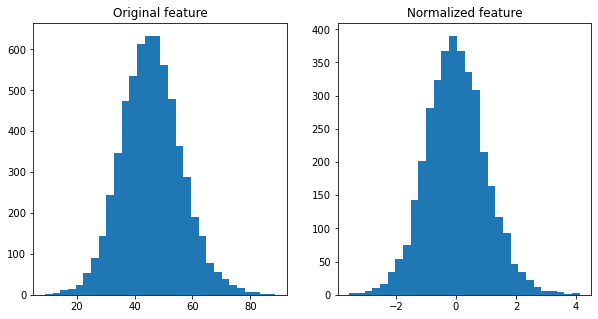

In [4]:
import matplotlib.pyplot as plt

feature_idx = 200  # Choose the index of the feature you want to plot
original_feature = data.iloc[:, start_col + feature_idx]
normalized_feature = X_train[:, feature_idx]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(original_feature, bins=30)
plt.title('Original feature')
plt.subplot(1, 2, 2)
plt.hist(normalized_feature, bins=30)
plt.title('Normalized feature')
plt.show()


## II. DEVELOPING MODEL 1: LOGISTIC REGRESSION AND A NEURAL NETWORK

### Least Squares Approximation using LU Factorisation

In [7]:
import scipy.linalg as la

X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

alpha = 1e-3  # Regularization strength 
XtX = X_train.T @ X_train + alpha * np.eye(X_train.shape[1])


# XtX = X_train.T @ X_train
Xty = X_train.T @ y_train

# LU Factorization
P, L, U = la.lu(XtX)

# Forward substitution
y_temp = la.solve(L, P @ Xty)

# Backward substitution
w = la.solve(U, y_temp)

def logistic_function(x):
    return 1 / (1 + np.exp(-x))

y_train_pred = logistic_function(X_train @ w)
y_val_pred = logistic_function(X_val @ w)
y_test_pred = logistic_function(X_test @ w)


threshold = 0.5
y_train_pred_label = (y_train_pred >= threshold).astype(int)
y_val_pred_label = (y_val_pred >= threshold).astype(int)
y_test_pred_label = (y_test_pred >= threshold).astype(int)


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_train = accuracy_score(y_train, y_train_pred_label)
precision_train = precision_score(y_train, y_train_pred_label)
recall_train = recall_score(y_train, y_train_pred_label)
f1_train = f1_score(y_train, y_train_pred_label)

accuracy_val = accuracy_score(y_val, y_val_pred_label)
precision_val = precision_score(y_val, y_val_pred_label)
recall_val = recall_score(y_val, y_val_pred_label)
f1_val = f1_score(y_val, y_val_pred_label)

accuracy_test = accuracy_score(y_test, y_test_pred_label)
precision_test = precision_score(y_test, y_test_pred_label)
recall_test = recall_score(y_test, y_test_pred_label)
f1_test = f1_score(y_test, y_test_pred_label)

# Example of interpreting probabilities
for i, prob in enumerate(y_test_probabilities[:5]):  # Just showing the first 5 predictions
    print(f"Fight {i}: Probability of winning: {prob:.3f}")
    
auc_score = roc_auc_score(y_test, y_test_probabilities)
print(f"AUC-ROC Score: {auc_score:.3f}")

print("Training set evaluation:")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 score: {f1_train:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1 score: {f1_val:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 score {f1_test:.3f}")


NameError: name 'y_test_probabilities' is not defined

### Refining the Logistic Regression: Elastic Net Regularisation

In [9]:
from sklearn.linear_model import SGDClassifier

# Prepare the data
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Set regularization hyperparameters
alpha = 1e-3  # Regularization strength
l1_ratio = 0.5  # Ratio between L1 and L2 regularization

# Train the Elastic Net regularized logistic regression model
model = SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio, random_state=42)
model.fit(X_train, y_train)

# Predict labels and probabilities
y_train_pred_label = model.predict(X_train)
y_train_pred = model.predict_proba(X_train)[:, 1]

y_val_pred_label = model.predict(X_val)
y_val_pred = model.predict_proba(X_val)[:, 1]

y_test_pred_label = model.predict(X_test)
y_test_pred = model.predict_proba(X_test)[:, 1]

# Predict probabilities for the test set
y_test_probabilities = model.predict_proba(X_test)[:, 1]

# Example of interpreting probabilities
for i, prob in enumerate(y_test_probabilities[:5]):  # Just showing the first 5 predictions
    print(f"Fight {i}: Probability of winning: {prob:.3f}")


# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_test_probabilities)
print(f"AUC-ROC Score: {auc_score:.3f}")


accuracy_train = accuracy_score(y_train, y_train_pred_label)
precision_train = precision_score(y_train, y_train_pred_label)
recall_train = recall_score(y_train, y_train_pred_label)
f1_train = f1_score(y_train, y_train_pred_label)

accuracy_val = accuracy_score(y_val, y_val_pred_label)
precision_val = precision_score(y_val, y_val_pred_label)
recall_val = recall_score(y_val, y_val_pred_label)
f1_val = f1_score(y_val, y_val_pred_label)

accuracy_test = accuracy_score(y_test, y_test_pred_label)
precision_test = precision_score(y_test, y_test_pred_label)
recall_test = recall_score(y_test, y_test_pred_label)
f1_test = f1_score(y_test, y_test_pred_label)

print("Training set evaluation:")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 score: {f1_train:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1 score: {f1_val:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 score {f1_test:.3f}")


Fight 0: Probability of winning: 0.748
Fight 1: Probability of winning: 0.022
Fight 2: Probability of winning: 0.598
Fight 3: Probability of winning: 0.012
Fight 4: Probability of winning: 0.410
AUC-ROC Score: 0.902
Training set evaluation:
Accuracy: 0.865
Precision: 0.855
Recall: 0.877
F1 score: 0.866

Validation set evaluation:
Accuracy: 0.826
Precision: 0.829
Recall: 0.816
F1 score: 0.822

Test set evaluation:
Accuracy: 0.823
Precision: 0.815
Recall: 0.825
F1 score 0.820


### Introducing a Feed-foward Neural Network

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Identify significant independent variables
significant_variables = np.where(np.abs(w[1:]) > 1e-2)[0]  # Adjust the threshold as needed
X_train_nn = X_train[:, 1:][:, significant_variables]
X_val_nn = X_val[:, 1:][:, significant_variables]
X_test_nn = X_test[:, 1:][:, significant_variables]

# Add logistic regression predictions as an input
X_train_nn = np.hstack([X_train_nn, y_train_pred.reshape(-1, 1)])
X_val_nn = np.hstack([X_val_nn, y_val_pred.reshape(-1, 1)])
X_test_nn = np.hstack([X_test_nn, y_test_pred.reshape(-1, 1)])

# Create a simple feedforward neural network
model = models.Sequential()
model.add(layers.Dense(1, activation='sigmoid', input_shape=(X_train_nn.shape[1],)))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_nn, y_train, epochs=50, batch_size=32, validation_data=(X_val_nn, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_nn, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Epoch 1/50
114/114 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.7367 - val_loss: 0.4576 - val_accuracy: 0.7794
Epoch 2/50
114/114 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.7965 - val_loss: 0.4259 - val_accuracy: 0.7967
Epoch 3/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3955 - accuracy: 0.8135 - val_loss: 0.4153 - val_accuracy: 0.8099
Epoch 4/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3810 - accuracy: 0.8204 - val_loss: 0.4091 - val_accuracy: 0.8181
Epoch 5/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8327 - val_loss: 0.4061 - val_accuracy: 0.8165
Epoch 6/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.8316 - val_loss: 0.4028 - val_accuracy: 0.8230
Epoch 7/50
114/114 [==============================] - 0s 1ms/step - loss: 0.3592 - accuracy: 0.8327 - val_loss: 0.4022 - val_accuracy: 0.8230
Epoch 

### Evaluation

38/38 [==============================] - 0s 668us/step
Training set evaluation:
Accuracy: 0.871
Precision: 0.871
Recall: 0.870
F1 score: 0.870

Validation set evaluation:
Accuracy: 0.826
Precision: 0.835
Recall: 0.807
F1 score: 0.821

Test set evaluation:
Accuracy: 0.819
Precision: 0.824
Recall: 0.799
F1 score 0.812


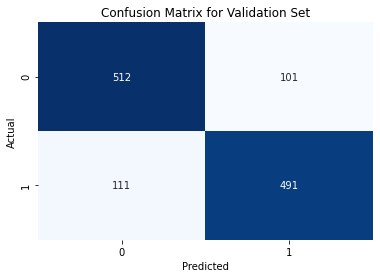

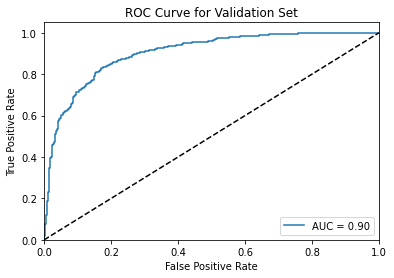

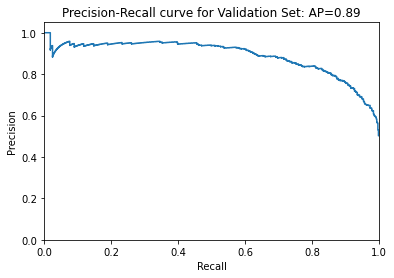

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, plot_confusion_matrix

# Get the predictions from the hybrid model
y_train_pred_nn = model.predict(X_train_nn)
y_val_pred_nn = model.predict(X_val_nn)
y_test_pred_nn = model.predict(X_test_nn)

# Apply the threshold
threshold = 0.5
y_train_pred_label_nn = (y_train_pred_nn >= threshold).astype(int)
y_val_pred_label_nn = (y_val_pred_nn >= threshold).astype(int)
y_test_pred_label_nn = (y_test_pred_nn >= threshold).astype(int)

# Calculate the evaluation metrics
accuracy_train_nn = accuracy_score(y_train, y_train_pred_label_nn)
precision_train_nn = precision_score(y_train, y_train_pred_label_nn)
recall_train_nn = recall_score(y_train, y_train_pred_label_nn)
f1_train_nn = f1_score(y_train, y_train_pred_label_nn)

accuracy_val_nn = accuracy_score(y_val, y_val_pred_label_nn)
precision_val_nn = precision_score(y_val, y_val_pred_label_nn)
recall_val_nn = recall_score(y_val, y_val_pred_label_nn)
f1_val_nn = f1_score(y_val, y_val_pred_label_nn)

accuracy_test_nn = accuracy_score(y_test, y_test_pred_label_nn)
precision_test_nn = precision_score(y_test, y_test_pred_label_nn)
recall_test_nn = recall_score(y_test, y_test_pred_label_nn)
f1_test_nn = f1_score(y_test, y_test_pred_label_nn)

# Print the evaluation results
print("Training set evaluation:")
print(f"Accuracy: {accuracy_train_nn:.3f}")
print(f"Precision: {precision_train_nn:.3f}")
print(f"Recall: {recall_train_nn:.3f}")
print(f"F1 score: {f1_train_nn:.3f}")

print("\nValidation set evaluation:")
print(f"Accuracy: {accuracy_val_nn:.3f}")
print(f"Precision: {precision_val_nn:.3f}")
print(f"Recall: {recall_val_nn:.3f}")
print(f"F1 score: {f1_val_nn:.3f}")

print("\nTest set evaluation:")
print(f"Accuracy: {accuracy_test_nn:.3f}")
print(f"Precision: {precision_test_nn:.3f}")
print(f"Recall: {recall_test_nn:.3f}")
print(f"F1 score {f1_test_nn:.3f}")



cm = confusion_matrix(y_val, y_val_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()

y_val_proba = y_val_pred  # Use predicted probabilities from the logistic function

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve for Validation Set: AP={average_precision:.2f}')
plt.show()


## III. DEVELOPING MODEL 2: SVM Classifier using QR Factorisation

### Performing the QR Decomposition

In [12]:
from scipy.stats import uniform, randint
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.linalg import qr

# Perform QR factorization on the training data
Q_train, R_train = qr(X_train)

# Transform the validation data using the R matrix obtained from the training data
X_val_transformed = np.dot(X_val, np.linalg.inv(R_train[:X_val.shape[1], :]))

# Transform the test data using the R matrix obtained from the training data
X_test_transformed = np.dot(X_test, np.linalg.inv(R_train[:X_test.shape[1], :]))

### Refining the Parameters

In [ ]:
param_dist = {
    'C': uniform(loc=0, scale=4),
    'gamma': uniform(loc=0, scale=0.1),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(2, 6),
    'coef0': uniform(loc=0, scale=1)
}

from sklearn.model_selection import RandomizedSearchCV

svm_classifier = SVC(probability=True)

random_search = RandomizedSearchCV(
    svm_classifier,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_val_transformed, y_val)

from sklearn.feature_selection import RFECV

svm_classifier_best = random_search.best_estimator_

rfe_cv = RFECV(svm_classifier_best, step=5, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
rfe_cv.fit(X_val_transformed, y_val)


print("Optimal number of features : %d" % rfe_cv.n_features_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 1250.3min


In [ ]:
importances = rfe_cv.grid_scores_
indices = np.argsort(importances)[::-1]
column_names = features.columns

print("Feature Ranking (Top 30):")

for i in range(30):
    index = indices[i]
    column_name = column_names[index]
    importance = importances[index]
    print(f"{i + 1}. {column_name} (Importance: {importance:.4f})")




### Training the SVM

In [ ]:
best_features = selector.get_support(indices=True)
X_train_selected = X_train[:, best_features]
X_val_selected = X_val[:, best_features]

# Retrieve the best hyperparameters from the RandomizedSearchCV
best_params = random_search.best_params_

# Create an SVM classifier with the best hyperparameters
svm_clf = SVC(**best_params)

# Train the SVM classifier using the selected features
svm_clf.fit(X_train_selected, y_train)

### Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


def print_metrics(y_true, y_pred, label):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{label} - Accuracy: {accuracy:.4f}")
    print(f"{label} - Precision: {precision:.4f}")
    print(f"{label} - Recall: {recall:.4f}")
    print(f"{label} - F1 Score: {f1:.4f}")

y_train_pred = svm_clf.predict_proba(X_train_selected)
print_metrics(y_train, y_train_pred, "Training")

y_val_pred = svm_clf.predict_proba(X_val_selected)
print_metrics(y_val, y_val_pred, "Validation")

X_test_selected = X_test[:, best_features]
y_test_pred = svm_clf.predict_proba(X_test_selected)
print_metrics(y_test, y_test_pred, "Test")

y_val_pred = svm_clf.predict_proba(X_val_selected)

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()

y_val_proba = svm_clf.decision_function(X_val_selected)

fpr, tpr, _ = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
average_precision = average_precision_score(y_val, y_val_proba)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve for Validation Set: AP={average_precision:.2f}')
plt.show()
